In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#plot the decision tree
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


#load file
dataset = pd.read_csv(r"./Dataset/dataset.csv")

In [3]:
def clean_data(x):                                                                            #we define a "cleaning" function which removes any spaces in front or after the string
    if isinstance(x, str):                                                                    #Check if (object,type)
        return x.strip().replace("  ", " ").replace(" _", "_").replace("_ ", "_")             #eemove spaces from both ends of the string
    else:
        return x  


# apply the function to each column
for col in dataset.columns:
    dataset[col] = dataset[col].map(clean_data)

#we now will make the checklist of all symptoms
#List of symptom columns
symptom_cols = [
    'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5',
    'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10',
    'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14', 'Symptom_15',
    'Symptom_16', 'Symptom_17'
]
#create the empty list to store all symptoms
all_symptoms = []

for col in symptom_cols:                           # go through each Symptom_1 to Symptom_17 column
    for symptom in dataset[col]:                   # go through every value in that column
        if pd.notna(symptom):                      # check if the cell is not nan
            all_symptoms.append(symptom)           # add it to the list

unique_symptoms = sorted(list(set(all_symptoms)))  #to remove the duplicates with set, we make them again a list (makes it usable for indexing and loops) and we soort them alphabetically in order to read them easier


#create a list of all diseases
disease_list = dataset['Disease'].unique()      #we use the unique function to get all diseases

#print how many symptoms we found
print("Number of unique symptoms:", len(unique_symptoms))
print("Symptoms:", unique_symptoms)

print("Number of unique diseases:", len(disease_list))
print("Symptoms:", disease_list)

binary = pd.DataFrame()                  #Create a new, empty table (DataFrame) named binary to hold the simplified data
binary['Disease'] = dataset['Disease']  #Copy the disease column from the original dataset (dataset) into the binary table

#for each syptom we check ecah row
for symptom in unique_symptoms:
    binary[symptom] = dataset[symptom_cols].eq(symptom).any(axis=1).astype(int)
#so what we basically did : For each symptom in your list, check every patient.Mark 1 if the patient has this symptom anywhere, or 0 if not




Number of unique symptoms: 131
Symptoms: ['abdominal_pain', 'abnormal_menstruation', 'acidity', 'acute_liver_failure', 'altered_sensorium', 'anxiety', 'back_pain', 'belly_pain', 'blackheads', 'bladder_discomfort', 'blister', 'blood_in_sputum', 'bloody_stool', 'blurred_and_distorted_vision', 'breathlessness', 'brittle_nails', 'bruising', 'burning_micturition', 'chest_pain', 'chills', 'cold_hands_and_feets', 'coma', 'congestion', 'constipation', 'continuous_feel_of_urine', 'continuous_sneezing', 'cough', 'cramps', 'dark_urine', 'dehydration', 'depression', 'diarrhoea', 'dischromic_patches', 'distention_of_abdomen', 'dizziness', 'drying_and_tingling_lips', 'enlarged_thyroid', 'excessive_hunger', 'extra_marital_contacts', 'family_history', 'fast_heart_rate', 'fatigue', 'fluid_overload', 'foul_smell_of urine', 'headache', 'high_fever', 'hip_joint_pain', 'history_of_alcohol_consumption', 'increased_appetite', 'indigestion', 'inflammatory_nails', 'internal_itching', 'irregular_sugar_level', '

C:\Users\louis\AppData\Local\Temp\ipykernel_9032\1799936109.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  binary[symptom] = dataset[symptom_cols].eq(symptom).any(axis=1).astype(int)
C:\Users\louis\AppData\Local\Temp\ipykernel_9032\1799936109.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  binary[symptom] = dataset[symptom_cols].eq(symptom).any(axis=1).astype(int)
C:\Users\louis\AppData\Local\Temp\ipykernel_9032\1799936109.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

In [4]:
#Prepare the data
X_binary = binary.drop(columns=['Disease'])  # All columns except Disease
y_binary = binary['Disease']  # Target column



#Split the data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary, test_size=0.7, random_state=42)

### Decision Tree

In [7]:

param_grid = {'ccp_alpha': [0.1, .01, .001, .0001],
              'max_depth' : range(15,25,1),
              'criterion' :['gini', 'entropy','log_loss'],
             }

model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train_bin, y_train_bin)

final_model = grid_search.best_estimator_

#Save the model

joblib.dump(final_model, './models_fulldata/decision_tree_model.pkl')



print(final_model)


# Train
final_model.fit(X_train_bin, y_train_bin)


# Prediction
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))



Fitting 5 folds for each of 120 candidates, totalling 600 fits
DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=20,
                       random_state=42)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        77
                                  AIDS       0.93      0.93      0.93        84
                                  Acne       1.00      0.93      0.96        87
                   Alcoholic hepatitis       0.93      1.00      0.96        82
                               Allergy       0.74      1.00      0.85        86
                             Arthritis       1.00      0.93      0.96        86
                      Bronchial Asthma       1.00      0.93      0.96        87
                  Cervical spondylosis       1.00      0.93      0.96        87
                           Chicken pox       1.00      0.86      0.93        87
                   Ch

[Text(0.6983333333333334, 0.9761904761904762, 'fatigue <= 0.5\nentropy = 5.35\nsamples = 1476\nvalue = [43, 36, 33, 38, 34, 34, 33, 33, 33, 33, 44, 34\n39, 35, 39, 38, 39, 30, 42, 32, 38, 35, 33, 33\n37, 39, 41, 29, 36, 41, 40, 38, 34, 39, 30, 35\n35, 31, 41, 37, 32]\nclass = Hypertension'),
 Text(0.5155555555555555, 0.9285714285714286, 'vomiting <= 0.5\nentropy = 4.74\nsamples = 897\nvalue = [43, 36, 33, 38, 34, 34, 3, 33, 0, 33, 0, 0, 2\n35, 39, 38, 39, 30, 42, 1, 2, 4, 2, 33, 1, 2\n6, 29, 0, 41, 40, 38, 34, 39, 2, 35, 1, 0, 41\n2, 32]\nclass = Fungal infection'),
 Text(0.6069444444444445, 0.9523809523809523, 'True  '),
 Text(0.4177777777777778, 0.8809523809523809, 'skin_rash <= 0.5\nentropy = 4.251\nsamples = 546\nvalue = [2.0, 36.0, 33.0, 2.0, 34.0, 34.0, 3.0, 33.0, 0.0\n2.0, 0.0, 0.0, 2.0, 35.0, 39.0, 38.0, 3.0, 3.0, 4.0\n1.0, 2.0, 0.0, 0.0, 33.0, 1.0, 0.0, 6.0, 29.0, 0.0\n4.0, 40.0, 38.0, 3.0, 2.0, 2.0, 35.0, 0.0, 0.0, 41.0\n2.0, 4.0]\nclass = Urinary tract infection'),
 Text(0.3

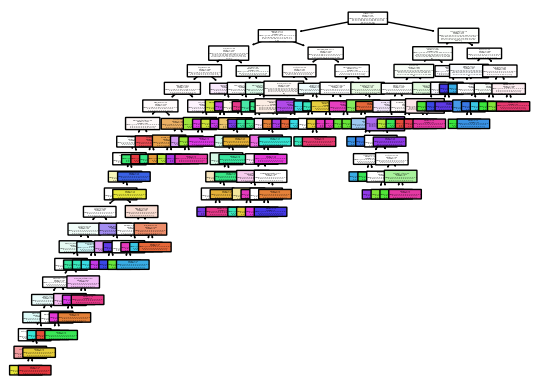

In [5]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plot_tree(final_model, filled=True, feature_names=X_binary.columns, class_names=y_binary.unique(), rounded=True)

In [5]:
# matrix
from sklearn.metrics import confusion_matrix

import seaborn as sns
# Create confusion matrix
cm = confusion_matrix(y_test_bin, predictions)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_binary.unique(), yticklabels=y_binary.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
# Save the model

NameError: name 'predictions' is not defined

### RANDOM FOREST

In [8]:

param_grid = {'n_estimators': range(40, 46, 1),
              'max_depth' : range(12,15,1),
              'criterion' :['gini', 'entropy','log_loss'],
             }

model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train_bin, y_train_bin)

final_model = grid_search.best_estimator_
joblib.dump(final_model, './models_fulldata/random_forest_model.pkl')
print(final_model)


# Train
final_model.fit(X_train_bin, y_train_bin)


# Prediction
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
RandomForestClassifier(max_depth=13, n_estimators=41, random_state=42)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        77
                                  AIDS       1.00      1.00      1.00        84
                                  Acne       1.00      1.00      1.00        87
                   Alcoholic hepatitis       1.00      1.00      1.00        82
                               Allergy       1.00      1.00      1.00        86
                             Arthritis       1.00      1.00      1.00        86
                      Bronchial Asthma       1.00      1.00      1.00        87
                  Cervical spondylosis       1.00      1.00      1.00        87
                           Chicken pox       1.00      1.00      1.00        87
                   Chronic cholestasis       1.00      1.00      1

### Logistic Regression

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# Create a pipeline with StandardScaler and LogisticRegression



param_grid = {'tol' : [.001,0.02,.005,.01,.02],
                'C' : [0.1, 0.5, 1, 2, 5],
              'solver' :['lbfgs', 'newton-cg', 'sag', 'saga'],
             }

# Create a logistic regression model
model = LogisticRegression(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train_bin, y_train_bin)

final_model = grid_search.best_estimator_
joblib.dump(final_model, './models_fulldata/logistic_regression_model.pkl')
print(final_model)


# Train
final_model.fit(X_train_bin, y_train_bin)


# Prediction
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
LogisticRegression(C=0.1, random_state=42, tol=0.001)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        77
                                  AIDS       1.00      1.00      1.00        84
                                  Acne       1.00      1.00      1.00        87
                   Alcoholic hepatitis       1.00      1.00      1.00        82
                               Allergy       1.00      1.00      1.00        86
                             Arthritis       1.00      1.00      1.00        86
                      Bronchial Asthma       1.00      1.00      1.00        87
                  Cervical spondylosis       1.00      1.00      1.00        87
                           Chicken pox       1.00      1.00      1.00        87
                   Chronic cholestasis       1.00      1.00      1.00        87
  

### Support Vector Classifier

In [14]:
from sklearn.svm import SVC


param_grid = {'C' : [.01,.02,.05,0.1, .2],
              'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree' : [1,2,3,4],
             }

# Create a logistic regression model
model = SVC(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train_bin, y_train_bin)
final_model = grid_search.best_estimator_
joblib.dump(final_model, './models_fulldata/support_vector_model.pkl')
print(final_model)
# Train
final_model.fit(X_train_bin, y_train_bin)
# Prediction
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
SVC(C=0.02, degree=1, kernel='linear', random_state=42)
                                        precision    recall  f1-score   support

(vertigo) Paroymsal Positional Vertigo       1.00      1.00      1.00        77
                                  AIDS       1.00      1.00      1.00        84
                                  Acne       1.00      1.00      1.00        87
                   Alcoholic hepatitis       1.00      1.00      1.00        82
                               Allergy       1.00      1.00      1.00        86
                             Arthritis       1.00      1.00      1.00        86
                      Bronchial Asthma       1.00      1.00      1.00        87
                  Cervical spondylosis       1.00      1.00      1.00        87
                           Chicken pox       1.00      1.00      1.00        87
                   Chronic cholestasis       1.00      1.00      1.00        87
 

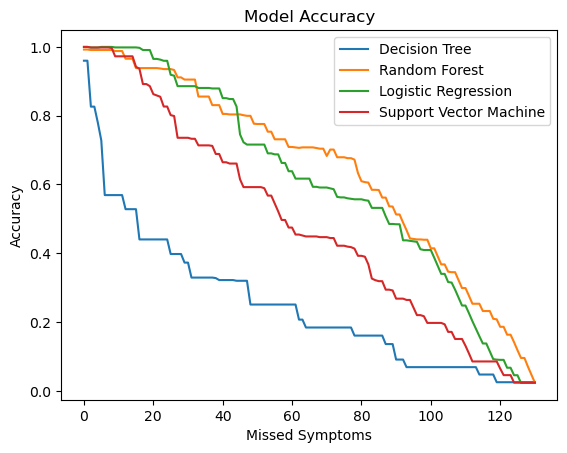

In [25]:


models = []

for model_name in ['decision_tree_model.pkl', 'random_forest_model.pkl', 'logistic_regression_model.pkl', 'support_vector_model.pkl']:
    model_path = f'./models_fulldata/{model_name}'
    model = joblib.load(model_path)
    models.append(model)

#drop a random symptom from a patient
X_sub = binary.drop(columns=['Disease'])  # All columns except Disease
y_sub = binary['Disease']  # Target column




#Split the data
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.7, random_state=42)

dt_accs = []
rf_acces = []
log_acces = []
svm_acces = []

accs = [dt_accs, rf_acces, log_acces, svm_acces]

np.random.seed(42)  # Set the random seed for reproducibility

for i in range(len(unique_symptoms)):

    index, columns = np.where(X_test_sub == 1)

    random_symptom_index = np.random.choice(columns)

    #print(f"Random Patient Index: {random_patient_index}, Random Symptom Index: {random_symptom_index}")


    X_test_sub.iloc[:, random_symptom_index] = 0 # Set the symptom to 0 (not present)

    for j in range(len(models)):
        predictions = models[j].predict(X_test_sub)

        # Evaluate the model
        accuracy = accuracy_score(y_test_sub, predictions)

        accs[j].append(accuracy)

# Plot the accuracies
plt.plot(accs[0], label='Decision Tree')
plt.plot(accs[1], label='Random Forest')
plt.plot(accs[2], label='Logistic Regression')
plt.plot(accs[3], label='Support Vector Machine')
plt.xlabel('Missed Symptoms')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.savefig('model_accuracy_test.png')
plt.show()

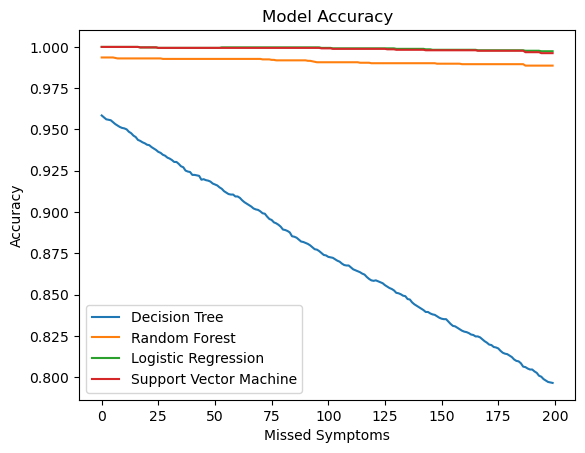

In [32]:
X_sub = binary.drop(columns=['Disease'])  # All columns except Disease
y_sub = binary['Disease']  # Target column




#Split the data
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.7, random_state=42)

dt_accs = []
rf_acces = []
log_acces = []
svm_acces = []

accs = [dt_accs, rf_acces, log_acces, svm_acces]

np.random.seed(42)  # Set the random seed for reproducibility

for i in range(200):
    #Drop a random symptom from a random patient
    index, columns = np.where(X_test_sub == 1)

    for k in range(100):

        random_patient_index = np.random.choice(index)
        random_symptom_index = np.random.choice(columns)

        #print(f"Random Patient Index: {random_patient_index}, Random Symptom Index: {random_symptom_index}")


        X_test_sub.iloc[random_patient_index, random_symptom_index] = 0 # Set the symptom to 0 (not present)

    for j in range(len(models)):
        predictions = models[j].predict(X_test_sub)

        # Evaluate the model
        accuracy = accuracy_score(y_test_sub, predictions)

        accs[j].append(accuracy)

# Plot the accuracies
plt.plot(accs[0], label='Decision Tree')
plt.plot(accs[1], label='Random Forest')
plt.plot(accs[2], label='Logistic Regression')
plt.plot(accs[3], label='Support Vector Machine')
plt.xlabel('Missed Symptoms')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.savefig('model_accuracy_test.png')
plt.show()
